In [89]:
import os, sys 
sys.path.append('../../gempy/')
# Importing GemPy
import gempy as gp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
from collections import OrderedDict
%matplotlib inline

In [109]:
from gempy.utils import create_topography
from gempy.core.grid_modules.grid_types import RegularGrid

In [125]:
grid = RegularGrid(extent=[0, 500, 0,500,-200,250],resolution = np.array([20,20,20])) #grid objekt

topo = create_topography.Load_DEM_artificial(grid, resolution = np.array([29,30])) # topography objekt

[160. 250.]


In [126]:
from scipy import interpolate

In [127]:
p1 = [200, 0]
p2 = [300,500]
section_x_res= 50 # die auflösung der section in x-richtung 

In [128]:
# die 2 funktionen müssten genauso in gempy in der sections klasse implementiert sein sofern das niemand geändert hat
def calculate_line_coordinates_2points(p1, p2, res):
    if isinstance(p1, list):
        p1 = np.array(p1)
    if isinstance(p2, list):
        p2 = np.array(p2)
    v = p2-p1 #vector pointing from p1 to p2
    u = v/np.linalg.norm(v) # normalize it
    distance = distance_2_points(p1, p2)
    steps = np.linspace(0, distance, res)
    values = p1.reshape(2, 1) + u.reshape(2, 1) * steps.ravel()
    return values.T

def distance_2_points(p1, p2):
    return np.sqrt(np.diff((p1[0], p2[0])) ** 2 + np.diff((p1[1], p2[1])) ** 2)

In [129]:
def slice_topo_RectBiSpline(p1, p2, xres, topography):
    xy = calculate_line_coordinates_2points(p1, p2, xres)
    xj = topography.values_3D[:,:,0][0,:]
    yj = topography.values_3D[:,:,1][:,0]
    zj = topography.values_3D[:,:,2].T
    f = interpolate.RectBivariateSpline(xj,yj,zj)
    zi = f(xy[:,0],xy[:,1])

    return xy[:,0], xy[:,1], np.diag(zi)

In [130]:
def slice_topo_interp2d(p1, p2, xres, topography, inter_kind='cubic'):
    xy = calculate_line_coordinates_2points(p1, p2, xres)
    xyz = topography.values_3D
    f = interpolate.interp2d(xyz[:,:,0].T, xyz[:,:,1].T, xyz[:,:,2].T, kind=inter_kind)
    zij = f(xy[:,0],xy[:,1])
    z = np.diag(zij)
    return xy[:,0], xy[:,1], z

In [131]:
x,y,z= slice_topo_RectBiSpline(p1, p2, section_x_res, topo) # RectBivariateSpline
x2,y2,z2= slice_topo_interp2d(p1, p2, section_x_res, topo) # interp2d
x3,y3,z3= slice_topo_interp2d(p1, p2, section_x_res, topo, inter_kind='linear') # interp2d

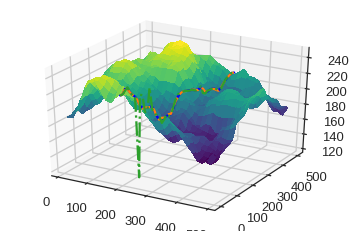

In [132]:
from mpl_toolkits.mplot3d import Axes3D

xyz = topo.values_3D
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(xyz[:,:,0], xyz[:,:,1], xyz[:,:,2], cmap='viridis',
                       linewidth=0, antialiased=False)
ax.plot(x,y,z,'b')
ax.plot(x2,y2,z2,'--')
ax.plot(x3,y3,z3,'-.')

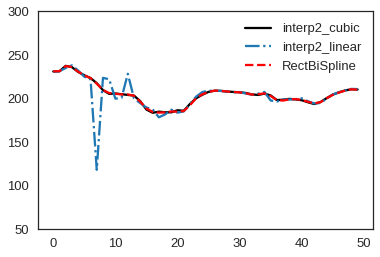

In [135]:
plt.plot(z2, 'k', label='interp2_cubic')
plt.plot(z3, '-.', label='interp2_linear')
plt.plot(z, 'r--', label='RectBiSpline')
plt.ylim(50,300)
plt.legend()